# Monte Carlo Strategy Backtesting

In [1]:
%pylab inline
import pandas as pd
from scipy.stats import norm

Populating the interactive namespace from numpy and matplotlib


### Remove trailing zeros


When creating moving averages we are losing a few periods at the head of the series. We want to fill this up with the first set value that we encounter in the series.

In [2]:
def remove_trailing_zeros(values):
    """Replace every 0 with 'nan' and return a copy."""
    start = 0
    for i in range(0, len(values)):
        start = i
        if values[i] != 0:
            break
    for i in range(0, start):
        values[i] = values[start]   
    return values

### Init

Initializing the Monte Carlo simulation with variables:

1. $u$ = the log mean
2. $Var$ = the log variance
3. $\text{Drift} = u - \dfrac{1}{2} \cdot \text{Var}$
4. $\text{Stdev} = \sqrt{\text{Var}}$ (standard deviation)

The following values have been calculated for Bitcoin for a time period of the previous three years.

* $u = 0.003717834$.
* $\text{Var} = 0.00172476$.

In [3]:
u = 0.003717834
var = 0.00172476
drift = u - (0.5 * var)
stdev = math.sqrt(var)

In [4]:
def generate_monte_carlo_chart(drift, stdev, t_intervals, start):
    daily_returns = np.exp(drift + stdev * norm.ppf(np.random.rand(t_intervals, 1)))
    price_list = np.zeros_like(daily_returns)
    price_list[0] = start
    for t in range(1, t_intervals):
        price_list[t] = price_list[t - 1] * daily_returns[t]
    return price_list

### Run the simulation

In [5]:
chart = generate_monte_carlo_chart(drift, stdev, 365, 12000)

## Indicators

### Simple Moving Average

In [6]:
def sma(values, n):
    sma = np.zeros_like(values)
    for i in range(n, len(values)):
        avg = np.sum(values[i-n:i])/n
        sma[i] = avg
    return remove_trailing_zeros(sma)

### MACD

In [7]:
def macd(values, ma1, ma2, sl):
    result = ma2 - ma1
    sma = np.ones_like(values) * result[sl]
    for i in range(sl-1, len(result)):
        avg = np.sum(result[i-sl:i])/sl
        sma[i] = avg
    return [result, sma]        

### Calculating the indicators

In [8]:
sma7 = sma(chart, 7)
sma14 = sma(chart, 14)
sma26 = sma(chart, 26)
sma12 = sma(chart, 12)
macd_ma, macd_sl = macd(chart, sma26, sma12, 9)

## Plotting the Monte Carlo series and Indicators

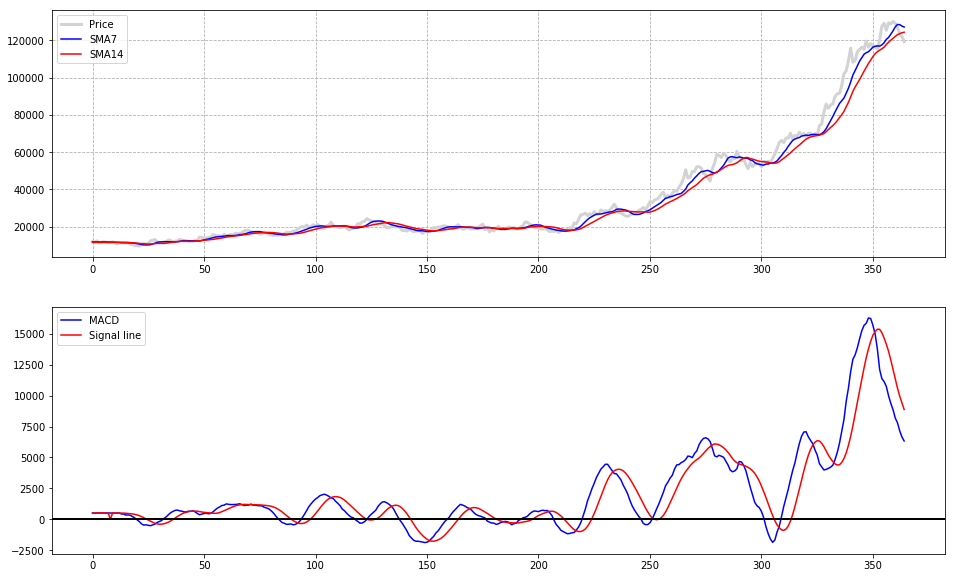

In [9]:
plt.figure(figsize=(16,10))
plt.subplot(2,1,1)
plt.plot(chart, c='lightgrey', lw=3);
plt.plot(sma7, c='b')
plt.plot(sma14, c='r')
legend(['Price', 'SMA7', 'SMA14']);
grid(linestyle='--')

plt.subplot(2,1,2)
plt.plot(macd_ma, c='b')
plt.plot(macd_sl, c='r')
#plt.fill_between(range(0, len(macd_area)), 0, np.array(macd_area), facecolor='lightgray')
plt.axhline(0,c='black',lw=2, linestyle='solid')
legend(['MACD', 'Signal line']);

## Strategies

In [10]:
equity_start = 1000

#### Stats

In [11]:
def strategy_backtest(signals):
    trades = []
    bought_at = 0
    no_of_trades = 0
    losing_streak = 0
    longest_losing_streak = 0
    equity = equity_start
    in_trade = False

    for i in range(0,len(signals)-1):
        if signals[i][0] == 'buy':
            bought_at = signals[i][1]
            in_trade = True
        else:
            if not in_trade: continue
                
            coefficient = chart[i]/chart[bought_at]

            if coefficient < 1:
                losing_streak += 1
                if losing_streak > longest_losing_streak:
                    longest_losing_streak = losing_streak
            else:
                losing_streak = 0
                
            trades.append([signals[i][1], coefficient])
            no_of_trades += 1
            in_trade = False
    
    index, coeff = zip(*trades)
    coeff_result = 1
    for c in coeff:
        equity *= c
        coeff_result *= c
        
    return {'equity_start': equity_start, 'equity_end': equity.item(0), 'coefficient': coeff_result.item(0)
            , 'no_of_trades':no_of_trades, 'losing_streak': longest_losing_streak, 'trades':trades}

### HODL

Easy thing to do...

In [12]:
def strategy_hodl(ch):
    signals = []
    signals.append(['buy', 0])
    signals.append(['sell', len(ch)-1])
    return signals

In [13]:
signals = strategy_hodl(chart)
strategy_hodl_result = strategy_backtest(signals)

ValueError: not enough values to unpack (expected 2, got 0)

In [ ]:
print('Hodling yields: %f, equity %f (Started with: %i)' % (strategy_hodl_result['coefficient'], strategy_hodl_result['coefficient'] * equity_start, equity_start))

####  Multiple tests

In [14]:
%%time

N = 5
coefficients = []

for i in range(0, N): 
    c = generate_monte_carlo_chart(drift, stdev, 365, 12000)
    signals = strategy_hodl(c)
    result = strategy_backtest(signals)
    coefficients.append(result['coefficient'])

ValueError: not enough values to unpack (expected 2, got 0)

In [ ]:
coefficients

In [ ]:
pl = np.mean(coefficients)
print('After %i runs the P/L is %f' % (N, pl))

### MACD Crossover Strategy

This is a very simple strategy where we go long when the MACD crosses into the positive zone and go short when the MACD is in the negative zone.

* Add EMA!
* Fix crossover!

#### Generating signals

In [ ]:
def strategy_macd_crossover(chart, macd, sl):
    start = 0
    for i in range(0,len(sl)):
        start = i
        if not np.isnan(sl[i]):
            break
            
    macd_prev = sl[i]
    signals = []
    for i in range(start, len(chart)):
        if macd_prev-sl[i] < 0 and macd[i]-sl[i] > 0:
            signals.append(['buy', i])
        elif macd_prev-sl[i] > 0 and macd[i]-sl[i] < 0:
            signals.append(['sell', i])
        macd_prev = macd[i]

    if signals[len(signals)-1][0] == 'buy':
        signals.append(['sell', len(chart)-1])
        
    return signals

In [ ]:
signals = strategy_macd_crossover(chart, macd_ma, macd_sl)
len(signals)

#### Plotting the signals

In [ ]:
plt.figure(figsize=(16,10))
plt.subplot(2,1,1)
plt.plot(chart, c='lightgrey', lw=3);
plt.plot(sma7, c='b')
plt.plot(sma14, c='r')
legend(['Price', 'SMA7', 'SMA14']);
grid(linestyle='--')
for s in signals:
    color = 'red'
    if s[0] == 'buy':
        color = 'green'
    plt.axvline(s[1],c=color,lw=1, linestyle='--')
    
plt.subplot(2,1,2)
plt.plot(macd_ma, c='b')
plt.plot(macd_sl, c='r')
plt.axhline(0,c='black',lw=2, linestyle='solid')
plt.tight_layout(h_pad=0)
legend(['MACD', 'Signal line']);
for s in signals:
    color = 'red'
    if s[0] == 'buy':
        color = 'green'
    plt.axvline(s[1],c=color,lw=1, linestyle='--')

The strategy is overtrading a lot which is the main cause for it's poor results.

In [ ]:
macd_strategy_result = strategy_backtest(signals)

In [ ]:
macd_strategy_result['coefficient']

In [ ]:
macd_strategy_result['equity_end']

In [ ]:
print('MACD Signal Trading yields: %i trades, equity %f (Started with %i)' % (macd_strategy_result['no_of_trades'], macd_strategy_result['equity_end'], macd_strategy_result['equity_start']))

In [ ]:
print('Stdev: %f' % math.sqrt(np.var([c[1] for c in macd_strategy_result['trades']])))

In [ ]:
print('Longest losing streak: %i' % macd_strategy_result['losing_streak'])

#### Multiple tests

In [ ]:
%%time
N = 1000
coefficients = []
for i in range(0, N):
    c = generate_monte_carlo_chart(drift, stdev, 365, 12000)
    ma1 = sma(c, 26)
    ma2 = sma(c, 12)
    macd_ma, macd_sl = macd(c, ma1, ma2, 9)
    signals = strategy_macd_crossover(c, macd_ma, macd_sl)
    backtest = strategy_backtest(signals)
    coefficients.append(backtest['coefficient'])

In [ ]:
pl = np.mean(coefficients)
print('After %i runs the P/L is %f' % (N, pl))

## To do

Add:

* Equity curve plot
* Exponential Moving Average
* Relative Strength Index
* Bollinger Bands
* Fix that stupid HODLing message
* Moving Averages Crossover Strategy for any $n$-periods